<form action="index.ipynb">
    <input type="submit" value="Return to Index" style="background-color: green; color: white; width: 150px; height: 35px; float: right"/>
</form>

# Viscoelasticity Example
Author(s): Paul Miles | Date Created: July 18, 2019

In this example we highlight the use of `pymcmcstat` in the analysis of linear viscoelasticity in the dielectric elastomer Very High Bond (VHB) 4910, made by 3M.  Dielectric elastomers are known for their large-field induced deformation and broad applications in smart structures, but the rate-dependent viscoelastic effects are not well understood. To address this issue, we quantify both the hyperelastic and viscoelastic constitutive behavior and use Bayesian uncertainty analysis to assess several key modeling attributes. Specifically, we couple a nonaffine hyperelastic model with linear viscoelasticity.  For me details about the motivation behind this research as well as other aspects of the model development, please see the following publications:

- Miles, Paul, Michael Hays, Ralph Smith, and William Oates. "Bayesian uncertainty analysis of finite deformation viscoelasticity." Mechanics of Materials 91 (2015): 35-49. https://doi.org/10.1016/j.mechmat.2015.07.002

- Mashayekhi, Somayeh, Paul Miles, M. Yousuff Hussaini, and William S. Oates. "Fractional viscoelasticity in fractal and non-fractal media: Theory, experimental validation, and uncertainty analysis." Journal of the Mechanics and Physics of Solids 111 (2018): 134-156. https://doi.org/10.1016/j.jmps.2017.10.013

- Solheim, Hannah, Eugenia Stanisauskis, Paul Miles, and William Oates. "Fractional viscoelasticity of soft elastomers and auxetic foams." In Behavior and Mechanics of Multifunctional Materials and Composites XII, vol. 10596, p. 1059604. International Society for Optics and Photonics, 2018. https://doi.org/10.1117/12.2296666

In [66]:
# import required packages
import numpy as np
import scipy.io as sio
from pymcmcstat.MCMC import MCMC
from pymcmcstat.settings.DataStructure import DataStructure
import matplotlib.pyplot as plt
%matplotlib notebook
from time import time as timetest
import os
import pymcmcstat
print(pymcmcstat.__version__)

1.9.0


# Basic Modeling Framework
The experimental data provides information on the materials deformation and total stress response.  The viscoelastic nature of this material leads to significant hysteresis gaps during the loading and unloading cycles.  To model this behavior we consider two different physical components: a reversible hyperelastic model as well as a linear viscoelastic model.
## Nonaffine Hyperelastic Model
The basic form of the hyperelastic stress is
$$s_{\infty} = \frac{1}{3}G_c\lambda\Big(\frac{9\lambda_{max} - I_1}{3\lambda_{max} - I_1}\Big) + G_e\lambda^{-1/2}(1-\lambda) - \frac{p}{\lambda}$$
where $\lambda$ is the stretch, $I_1$ is the first stretch invariant, $p$ is the hydrostatic pressure term (enforces incompressibility), and $G_c, G_e$ and $\lambda_{max}$ are model parameters.  For details regarding the Nonaffine energy function, see

- Davidson, Jacob D., and N. C. Goulbourne. "A nonaffine network model for elastomers undergoing finite deformations." Journal of the Mechanics and Physics of Solids 61, no. 8 (2013): 1784-1797.

In [67]:
def nonaffine_hyperelastic(theta, stretch):
    # unpack model parameters
    Gc, Ge, lam_max = theta['Gc'], theta['Ge'], theta['lam_max']
    # Stretch Invariant
    I1 = stretch**2 + 2/stretch;
    # Hydrostratic pressure
    p = (Gc/3/stretch*((9*lam_max**2 - I1)/(3*lam_max**2 - I1))) + Ge/stretch**0.5*(1 - stretch);
    # 1st P-K stress in kPa
    Hc = 1/3*Gc*stretch*((9*lam_max**2 - I1)/(3*lam_max**2 - I1));
    He = Ge*(1-1/stretch**2);
    sigma_inf = Hc + He - p/stretch;
    return sigma_inf.reshape([sigma_inf.size,])

## Linear Viscoelastic Model
The linear viscoelastic model is simply a spring-dashpot system.
$$\dot{Q} + \frac{1}{\tau}Q = \gamma\dot{\lambda}$$
where $Q$ is the viscoelastic stress, and $\tau = \eta/\gamma$ is the viscoelastic time constant.

In [68]:
def linear_viscoelastic(theta, stretch, time):
    # unpack model parameters
    eta = theta['eta']
    gamma = theta['gamma']
    tau = eta/gamma  # viscoelastic time constant    
    dt = np.ones([stretch.size])  # time step
    dt[1:] = time[1:]-time[0:-1]
    n = stretch.size
    q = np.zeros([n,])
    for kk in range(1, n):
        Tnc = 1 - dt[kk]/(2*tau);
        Tpc = 1 + dt[kk]/(2*tau);
        Tpcinv = Tpc**(-1);
        q[kk] = Tpcinv*(Tnc*q[kk - 1] + gamma*(stretch[kk] - stretch[kk - 1]));
    return q

# Experimental Data

<IPython.core.display.Javascript object>


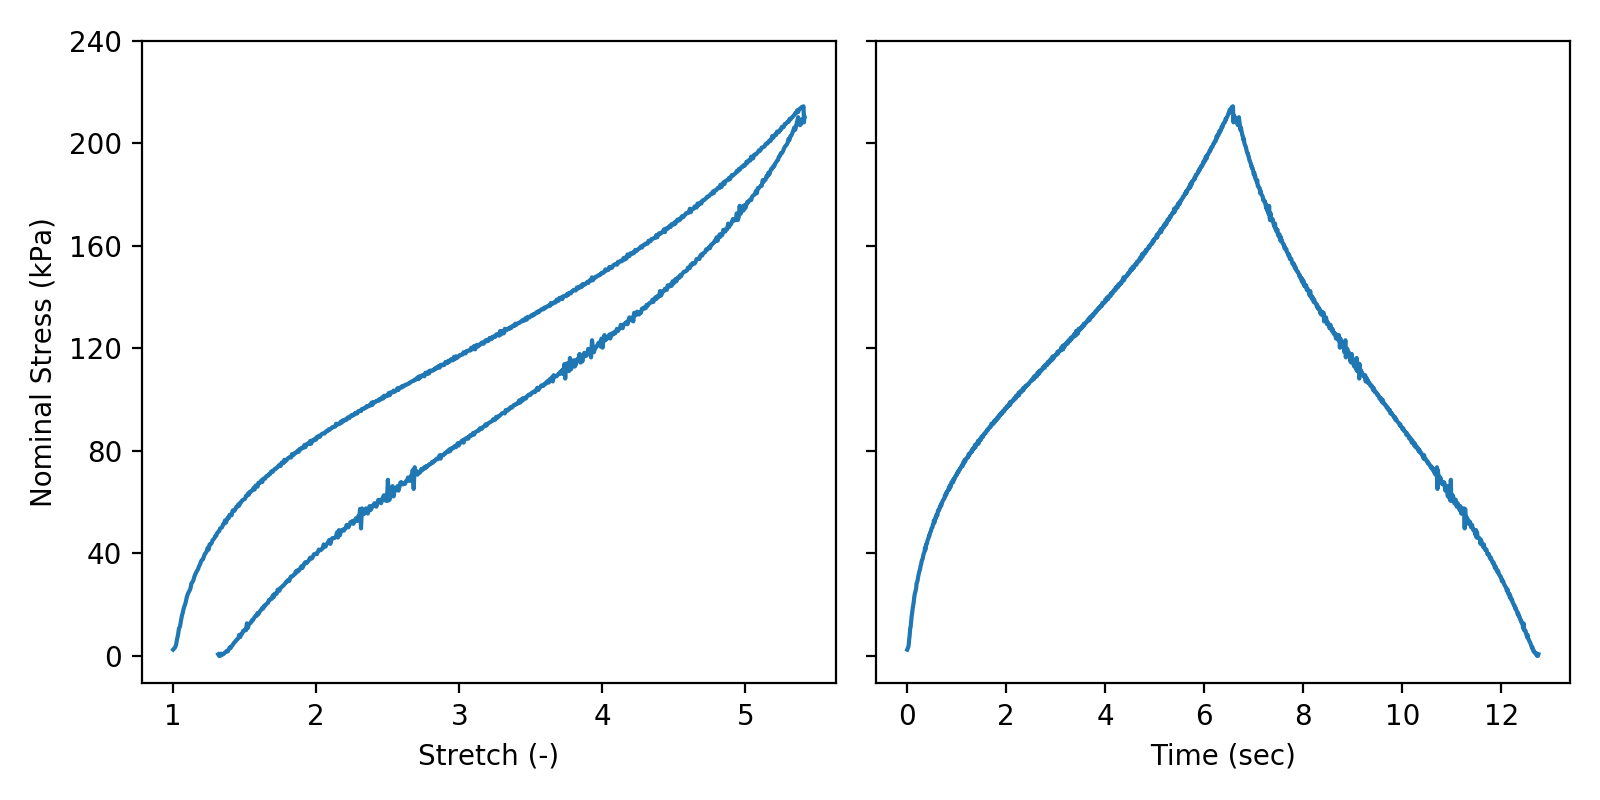

In [77]:
# Load data for VHB 4910
vhbdata = sio.loadmat('data_files' + os.sep + 'vhb4910_data.mat')
time = vhbdata['data']['xdata'][0][0][:,0]
stretch = vhbdata['data']['xdata'][0][0][:,1]
xdata = vhbdata['data']['xdata'][0][0][:, 0:2]
stress = vhbdata['data']['ydata'][0][0][:,0]
nds = len(time)

f, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
# Stretch vs. Stress
ax[0].plot(stretch, stress)
ax[0].set_xlabel('Stretch (-)')
ax[0].set_ylabel('Nominal Stress (kPa)')
# Time vs. Stress
ax[1].plot(time, stress)
ax[1].set_xlabel('Time (sec)')
ax[1].set_yticks(np.arange(0, 241, 40))
ax[0].set_yticks(np.arange(0, 241, 40))
f.tight_layout()

# Setup Model Parameters
- `theta0`: Initial parameter values
- `bounds`: Min/Max
- `names`: Reference names (keys)
- `longnames`: LaTeX style names for plotting

In [120]:
theta0 = dict(
        Gc=7.55,
        Ge=17.7,
        lam_max=4.8,
        eta=708.,
        gamma=31
        )
bounds = dict(
        Gc=[0, 1e5],
        Ge=[-1e5, 1e5],
        lam_max=[1, 1e2],
        eta=[0, 1e10],
        gamma=[0, 1e10]
        )
names = ['Gc', 'Ge', 'lam_max', 'eta', 'gamma']
longnames = ['$G_c$', '$G_e$', '$\\lambda_{max}$', '$\\eta$', '$\\gamma$']


# Test Evaluation

NHM function average evaluation time: 0.06613016128540039 ms
LVM function average evaluation time: 2.1443581581115723 ms


<IPython.core.display.Javascript object>


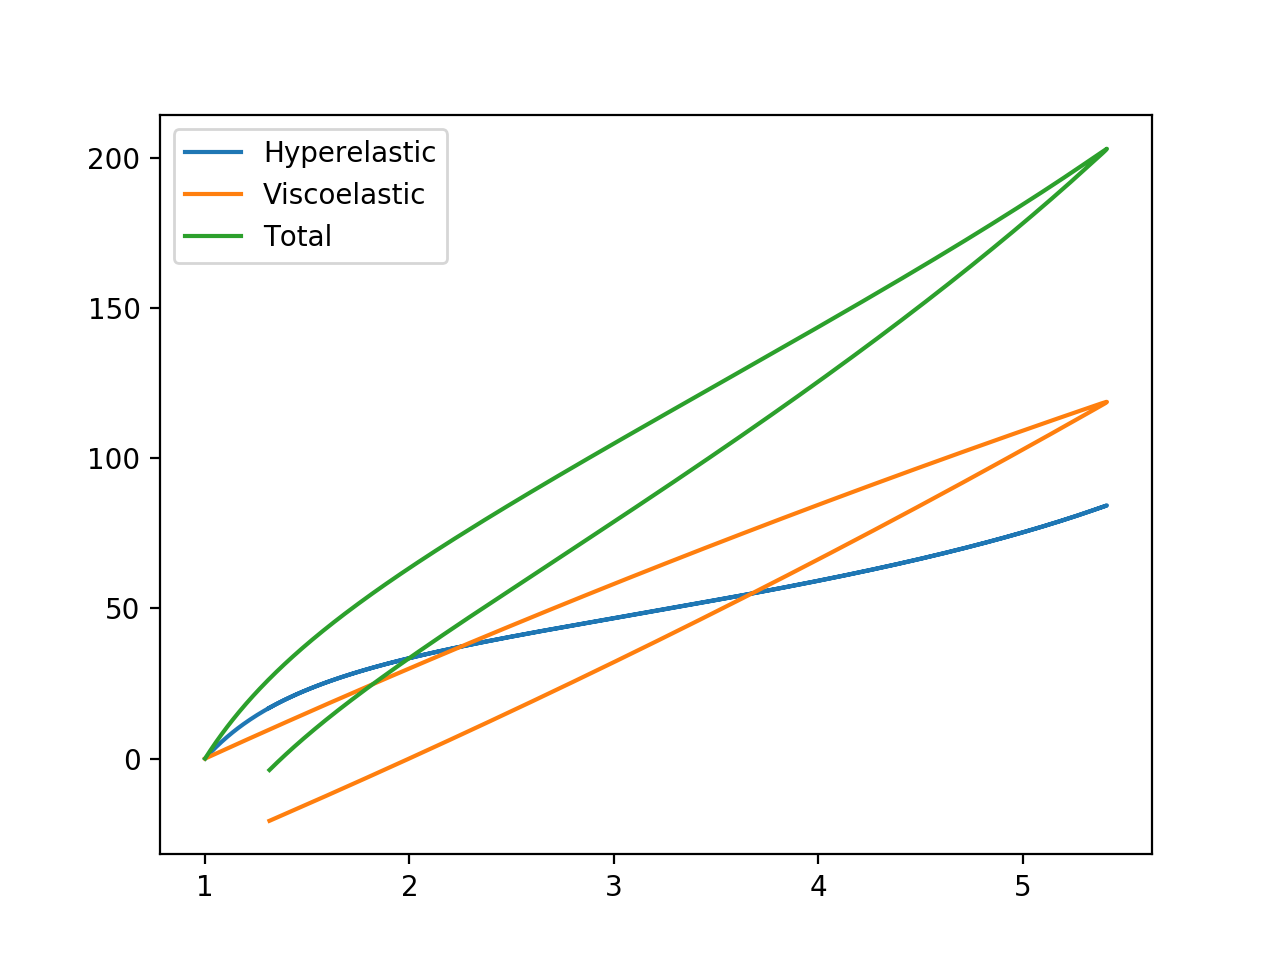

In [106]:
# Test hyperelastic model evaluation
n = 100
st = timetest()
for ii in range(n):
    sigma_inf = nonaffine_hyperelastic(theta0, stretch)
et = timetest()
print('NHM function average evaluation time: {} ms'.format((et - st)/n*1e3))

# Setup and test viscoelastic model evaluation
n = 100
st = timetest()
for ii in range(n):
    q = linear_viscoelastic(theta0, stretch, time)
et = timetest()
print('LVM function average evaluation time: {} ms'.format((et - st)/n*1e3))

# Plot total stress
f, ax = plt.subplots(1)
ax.plot(stretch, sigma_inf, label='Hyperelastic');
ax.plot(stretch, q, label='Viscoelastic');
ax.plot(stretch, sigma_inf + q, label='Total');
ax.legend();

# Test Sum-of-Squares Function

In [107]:
def model(q, data):
    time = data.xdata[0][:, 0]
    stretch = data.xdata[0][:, 1]
    theta = {'Gc': q[0], 'Ge': q[1], 'lam_max': q[2],
             'eta': q[3], 'gamma': q[4]}
    stress = (nonaffine_hyperelastic(theta, stretch) 
                    + linear_viscoelastic(theta, stretch, time))
    return stress

# Define sum-of-squares function and model settings
def ssfun(t, data):
    # Unpack data structure
    stress = data.ydata[0]
    # Evaluate model
    stress_model = model(t, data)
    # Calculate sum-of-squares error
    res = stress.reshape(stress_model.shape) - stress_model
    ss = np.dot(res.T, res)
    return ss

n = 100
st = timetest()
for ii in range(n):
    sstest = ssfun(theta0vec, mcstat.data)
et = timetest()
print('SOS function evaluation time: {} ms'.format((et - st)/n*1e3))

SOS function evaluation time: 2.3817896842956543 ms


# Specify Parameters to Sample
- `sample`: Flag to include parameter in MCMC sampling

In [164]:
from ipywidgets import interact
import ast

def g(Gc, Ge, lam_max, eta, gamma):
    return dict(
        Gc=Gc,
        Ge=Ge,
        lam_max=lam_max,
        eta=eta,
        gamma=gamma)

select_sample = interact(g, Gc=False, Ge=False, lam_max=False, eta=True, gamma=True)
sample_output = select_sample.widget.out

interactive(children=(Checkbox(value=False, description='Gc'), Checkbox(value=False, description='Ge'), Checkb…

# Setup & Run MCMC Simulation
Setup:
- Add data
- Add model parameters
- Define model settings include sum-of-squares function
- Define simulation options

Run and display chain statistics. We remove the first part of chain as the burnin period.

In [176]:
# Initialize MCMC object
mcstat = MCMC()
# Add data
mcstat.data.add_data_set(x=xdata,
                         y=stress)
# define model parameters
sample = ast.literal_eval(sample_output.outputs[0]['data']['text/plain'])
for ii, name in enumerate(names):
    mcstat.parameters.add_model_parameter(
            name=longnames[ii],
            theta0=theta0[name],
            minimum=bounds[name][0],
            maximum=bounds[name][1],
            sample=sample[name])
mcstat.model_settings.define_model_settings(sos_function = ssfun)
# Define simulation options
mcstat.simulation_options.define_simulation_options(
    nsimu=5.0e3,
    updatesigma=True)
# Run Simulation
mcstat.run_simulation()

results = mcstat.simulation_results.results
plotnames = results['names']
fullchain = results['chain']
fulls2chain = results['s2chain']
nsimu = results['nsimu']
burnin = int(nsimu/2)
chain = fullchain[burnin:, :]
s2chain = fulls2chain[burnin:, :]

mcstat.chainstats(chain, results)


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
    $\eta$:    708.00 [ 0.00e+00,  1.00e+10] N( 0.00e+00,      inf)
  $\gamma$:     31.00 [ 0.00e+00,  1.00e+10] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 5000 of 5000 complete in 22.0 sec

------------------------------
name      :       mean        std     MC_err        tau     geweke
$\eta$    :   734.4478    12.1746     0.7993     8.2018     0.9933
$\gamma$  :    33.2904     0.1793     0.0078     7.2799     0.9972
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 26.92%
Stage 2: 54.44%
Net    : 81.36% -> 4068/5000
---------------
Chain provided:
Net    : 84.80% -> 2120/2500
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


# Plot Chain Diagnostics

<IPython.core.display.Javascript object>


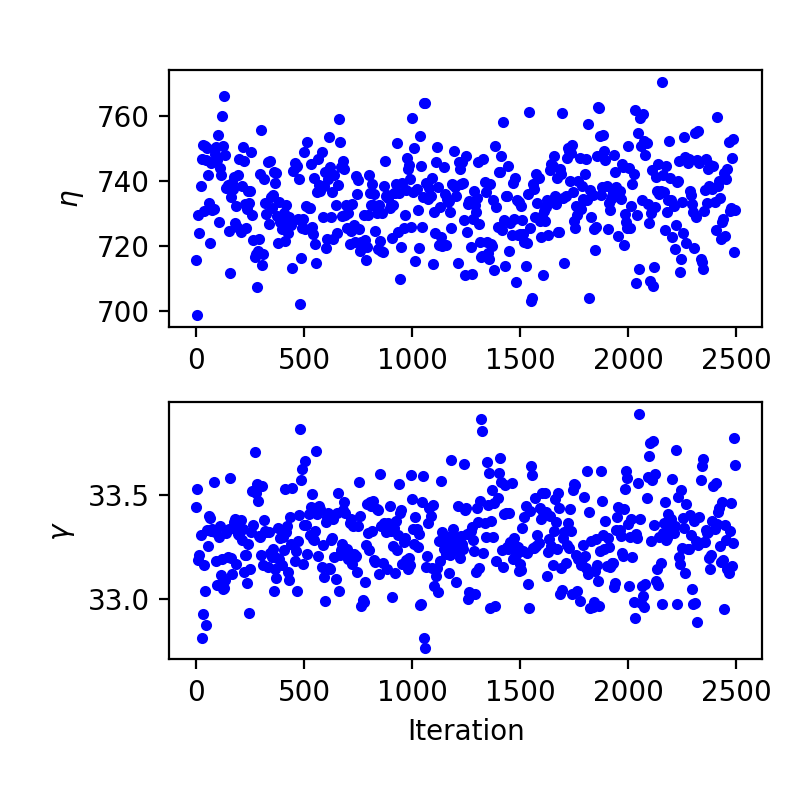

<IPython.core.display.Javascript object>


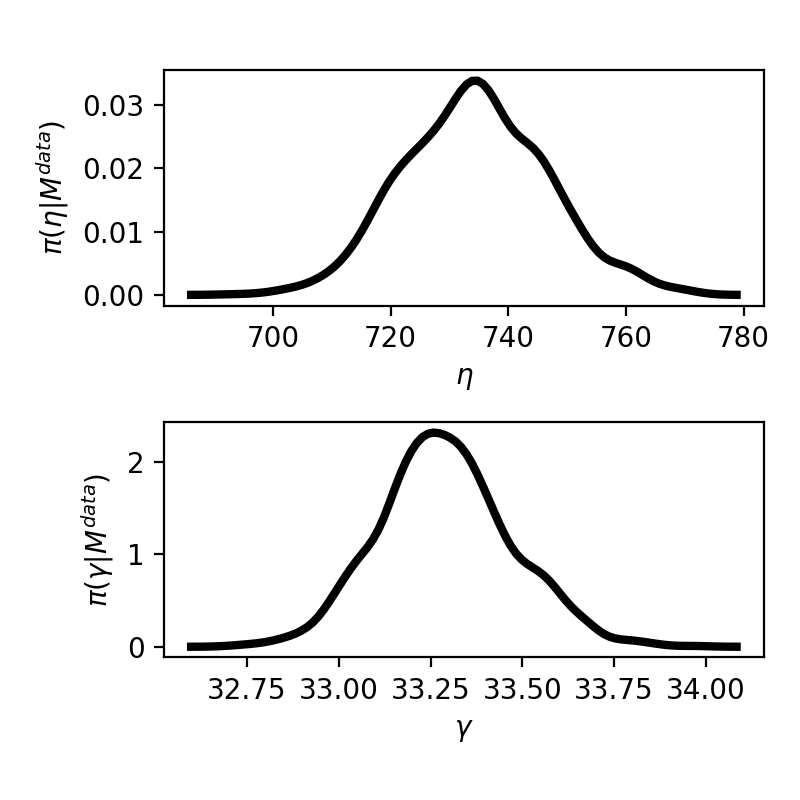

<IPython.core.display.Javascript object>


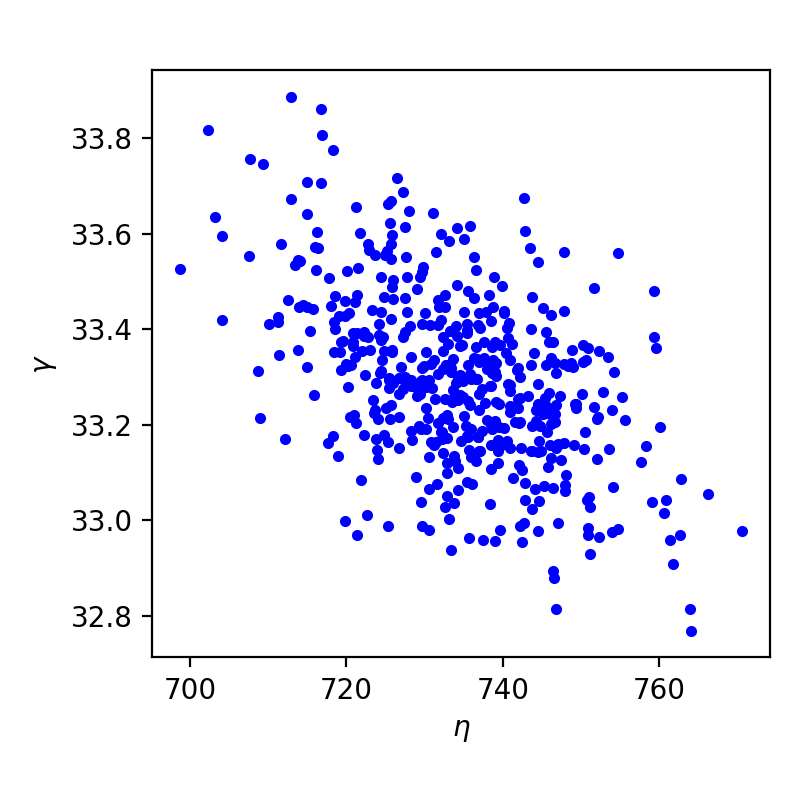

In [177]:
# plot chain metrics
from pymcmcstat import mcmcplot as mcp
settings = dict(fig=dict(figsize=(4, 4)))
mcp.plot_chain_panel(chain, plotnames, settings)
mcp.plot_density_panel(chain, plotnames, settings)
pwfig = mcp.plot_pairwise_correlation_panel(chain, plotnames,
                                                settings)

# Plotting Prediction/Credible Intervals
We can display the prediction/credible intervals in several different ways.
1. Plot intervals with respect to time.
2. Plot intervals with respect to stretch.

In either case, we can use the same function to generate the intervals.

## Plot Intervals With Respect to Time
This approach is fairly straight-forward.  We define a new data structure and define the `x` variable as `time`.  As the model evaluation requires both `stretch` and `time`, we include that information in the `user_define_object` variable.

In [178]:
from pymcmcstat import propagation as up
# plot wrt time
pdata = DataStructure()
pdata.add_data_set(x=xdata,
                   y=stress,
                   )
intervals = up.calculate_intervals(chain, results, pdata, model,
                                  s2chain=s2chain, nsample=500)

 [-----------------100%-----------------] 500 of 500 complete in 1.2 sec

<IPython.core.display.Javascript object>


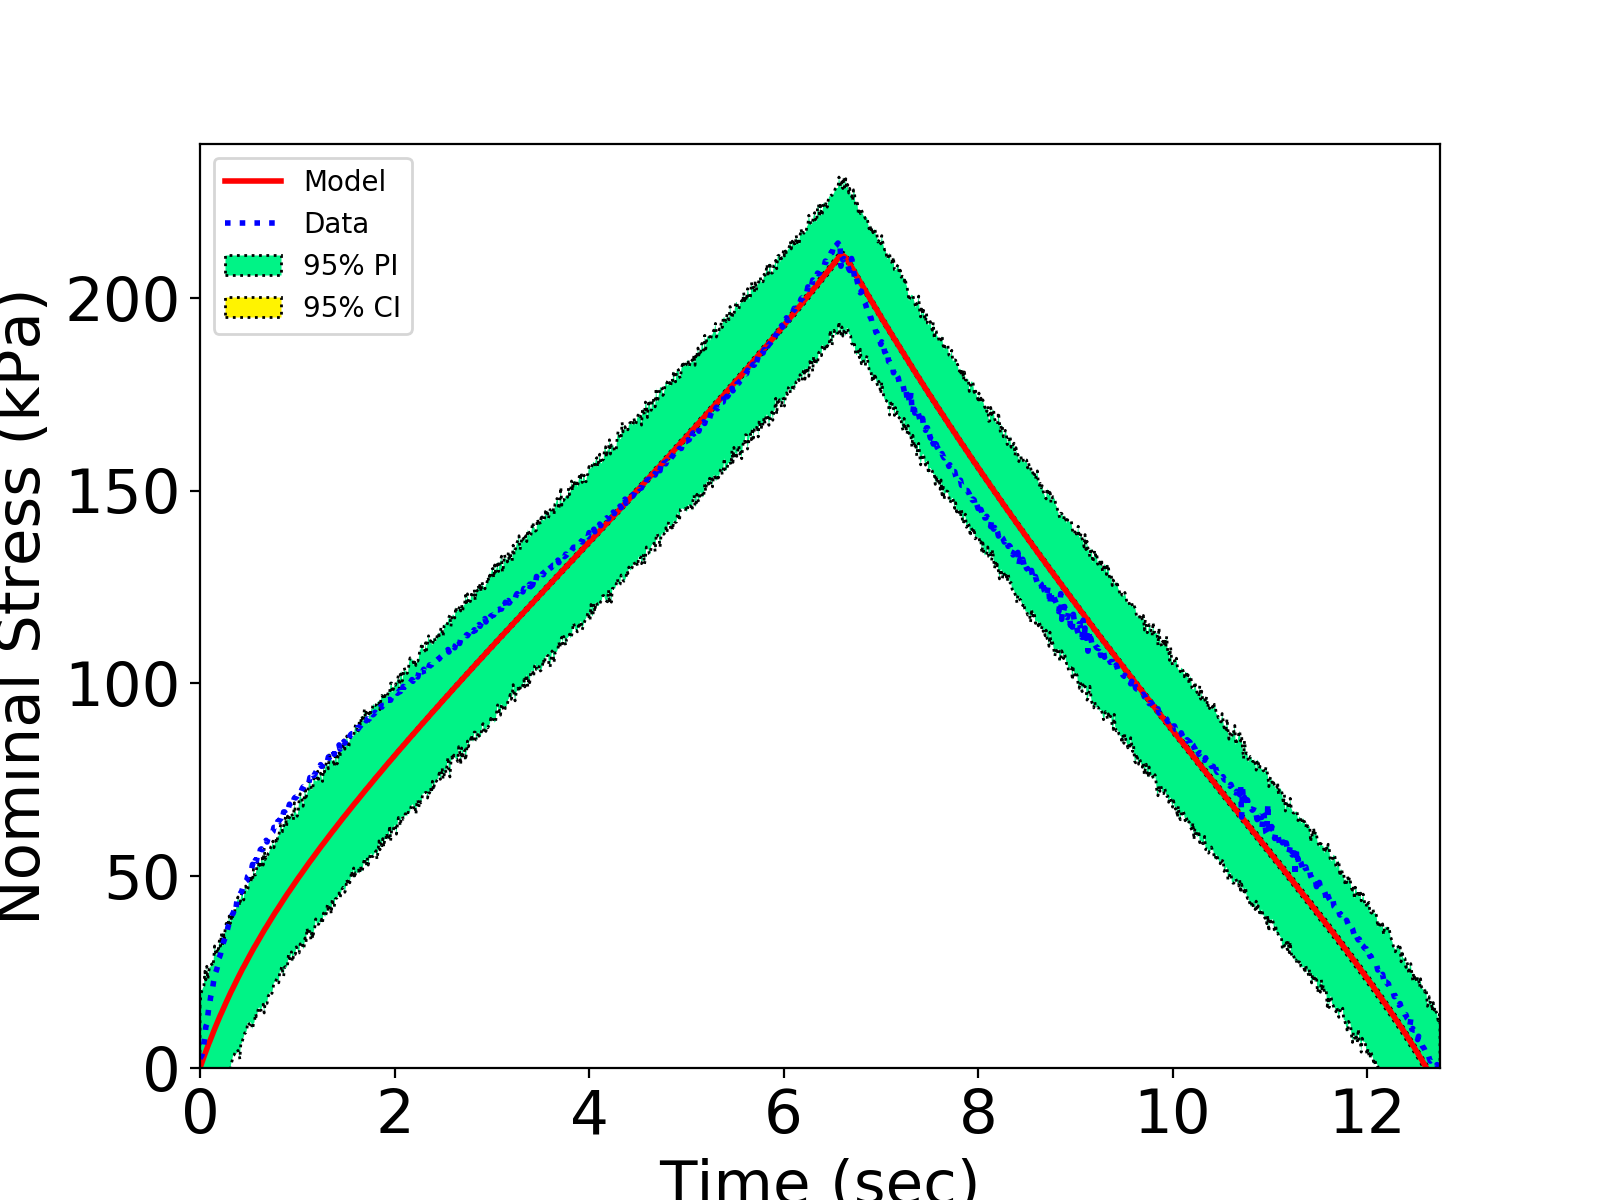

In [179]:
model_display = dict(
    color='r'
)
data_display = dict(
    linestyle=':',
    linewidth=2,
    color='b',
    marker=None
)
fig, ax = up.plot_intervals(
    intervals, time, stress,
    model_display=model_display,
    data_display=data_display,
    figsize=(8, 6))
ax.set_xlabel('Time (sec)', fontsize=22)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_ylabel('Nominal Stress (kPa)', fontsize=22)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax.set_xlim([0, time[-1]])
tmp = ax.set_ylim([0, 240])

## Plot Intervals With Respect to Stretch
This approach is made much more complicated due to a an interesting feature of the `fill_between` method in the `matplotlib` libary.  The behavior is the same as what you observe when using the MATLAB command `fill`.  If in the same call to the filling function the same area is filled more than once, the filling is actually undone.  To account for this we must break the plotting portion into two distinct sections: loading and unloading.  The interval generation is still the same however, and is accomplished by defining a new data structure with the `x` variable equal to `stretch`.

<IPython.core.display.Javascript object>


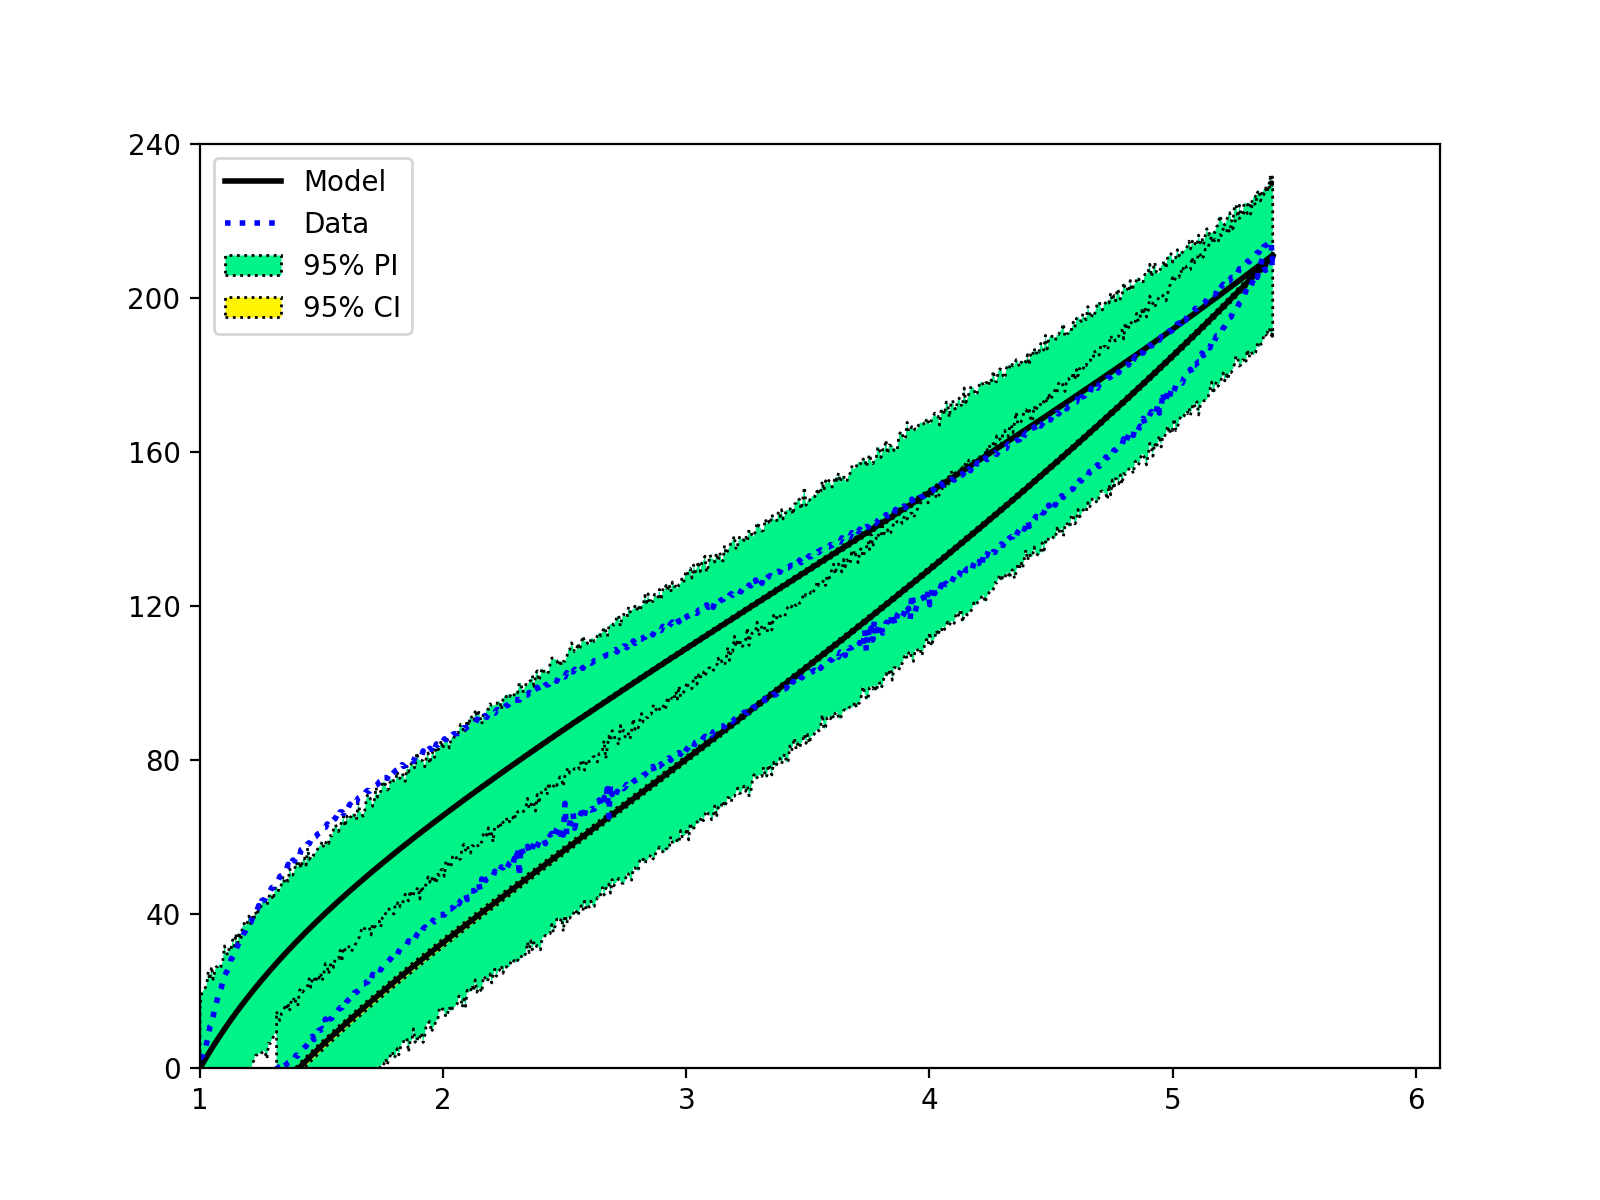

In [180]:
model_display = dict(
    color='r'
)
data_display = dict(
    linestyle=':',
    linewidth=2,
    color='b',
    marker=None
)

# max stretch
sid = np.argmax(stretch)
# 1. Loading
intervals_1 = {'credible': intervals['credible'][:, 0:sid],
               'prediction': intervals['prediction'][:, 0:sid]}
stretch_1 = stretch[0:sid]
stress_1 = stress[0:sid].reshape(stress[0:sid].size, 1)
stress = stress
# 2. Unloading
intervals_2 = {'credible': intervals['credible'][:, sid:],
               'prediction': intervals['prediction'][:, sid:]}
stretch_2 = stretch[sid:]
stress_2 = stress[sid:].reshape(stress[sid:].size, 1)


fig, ax = up.plot_intervals(
        intervals_1, stretch_1, ydata=stress_1,
        limits=[95], adddata=True, data_display=data_display)
fig, ax = up.plot_intervals(
        intervals_2, stretch_2, ydata=stress_2,
        limits=[95], fig=fig, adddata=True, data_display=data_display, addlegend=False)

fig.set_figwidth(8)
fig.set_figheight(6)
ax.set_xlim([1, 6.1])
ax.set_ylim([0, 240])
ax.set_yticks(np.arange(0, 241, 40))
ax.set_xticks(np.arange(1, 6.1, 1))
fig.show()

In this plot we have shown how uncertainty propagates through our model.  Depending on the combination of parameter values sampled, the amount of uncertainty can be quite large, which means our model is performing poorly.  While this result is interesting, it does not tell us how well the model behaves at predicting the material behavior at other rates.  Using the calibrated model to predict behavior at other rates resulted in poor model agreement.  This realization led to investigation of non-linear as well as fractional-order viscoelastic modeling approaches.  More details regarding this research can be found in the references listed as the top of the tutorial.

- Miles, Paul, Michael Hays, Ralph Smith, and William Oates. "Bayesian uncertainty analysis of finite deformation viscoelasticity." Mechanics of Materials 91 (2015): 35-49. https://doi.org/10.1016/j.mechmat.2015.07.002

- Mashayekhi, Somayeh, Paul Miles, M. Yousuff Hussaini, and William S. Oates. "Fractional viscoelasticity in fractal and non-fractal media: Theory, experimental validation, and uncertainty analysis." Journal of the Mechanics and Physics of Solids 111 (2018): 134-156. https://doi.org/10.1016/j.jmps.2017.10.013